In [1]:
from IPython.display import Image

# Benchtop Beam polarization mapping with HWP
##### 2016-04-29

#### Experiment setup
On the left, the ZBD is connected to the 4.8 mm horn through the isolator. The detector setup is mounted to the X-Y stage

On the right, the source is configured for broadband mode and has the 140-160 GHz filter connected to the standard gain 15 degree horn.

The sapphire HWP is directly in front of the horn and turned using a stepper motor. There is no AR coating on the HWP yet.

The distance between the horns is arbitrarily about 70 mm. This is a distance that would be reasonable for a vertically mounted package inside the cryostat. But we could also move the package further from the source horn to spread the power more evenly.

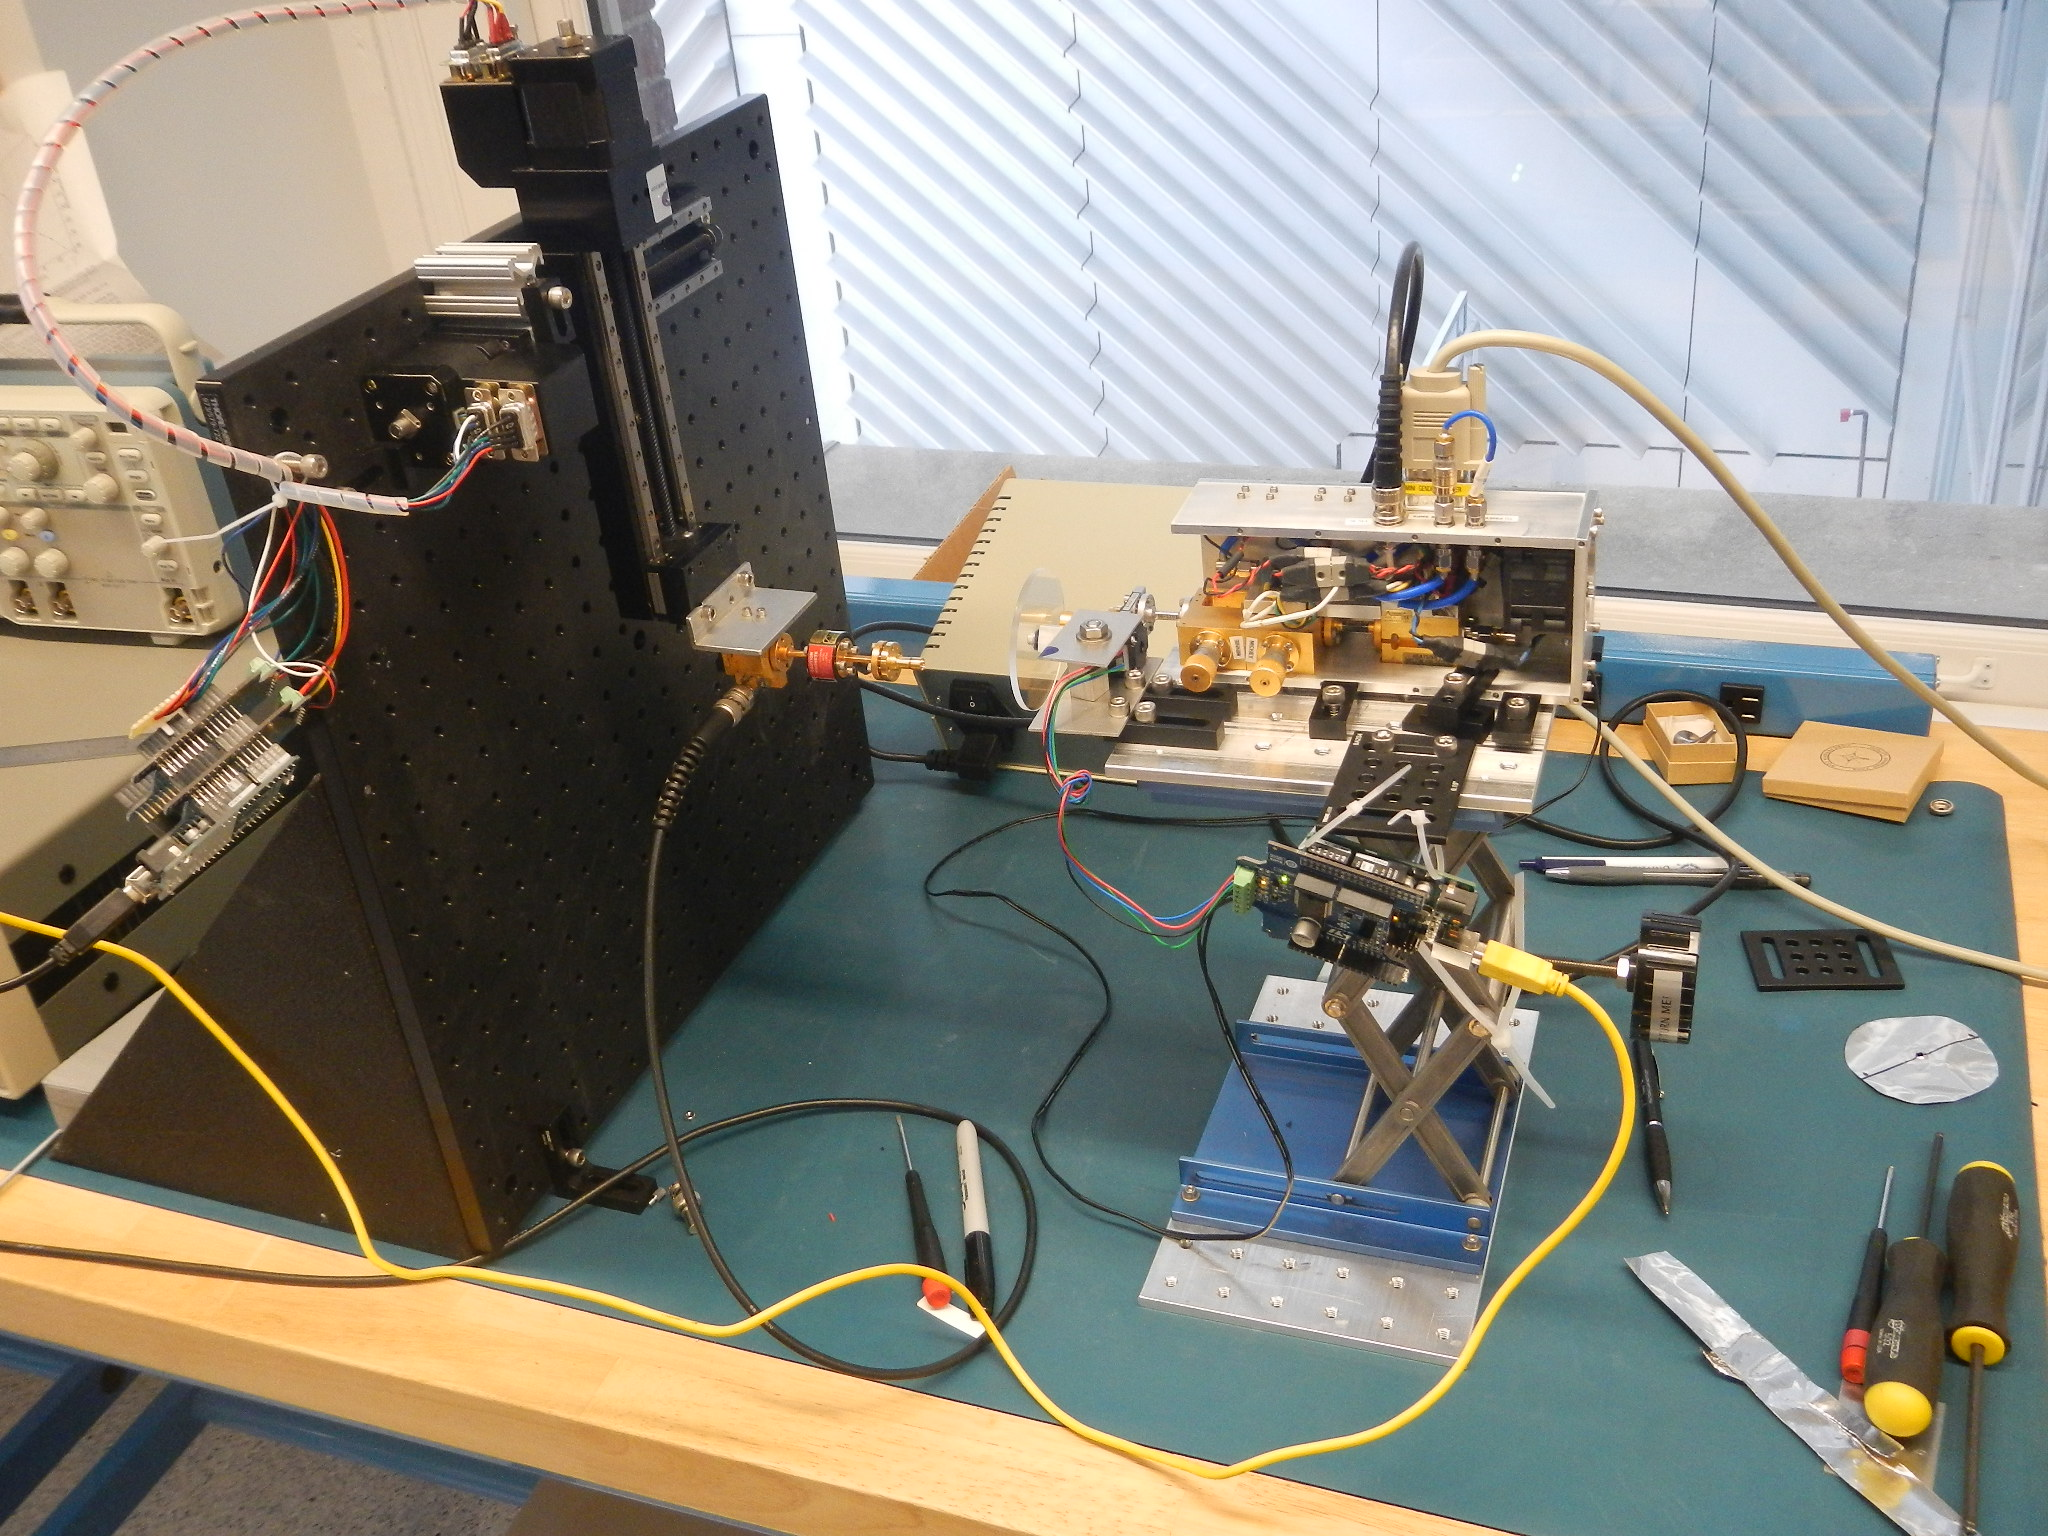

In [2]:
Image(filename='/artemis/photos/DSCN1185.JPG',width=800)

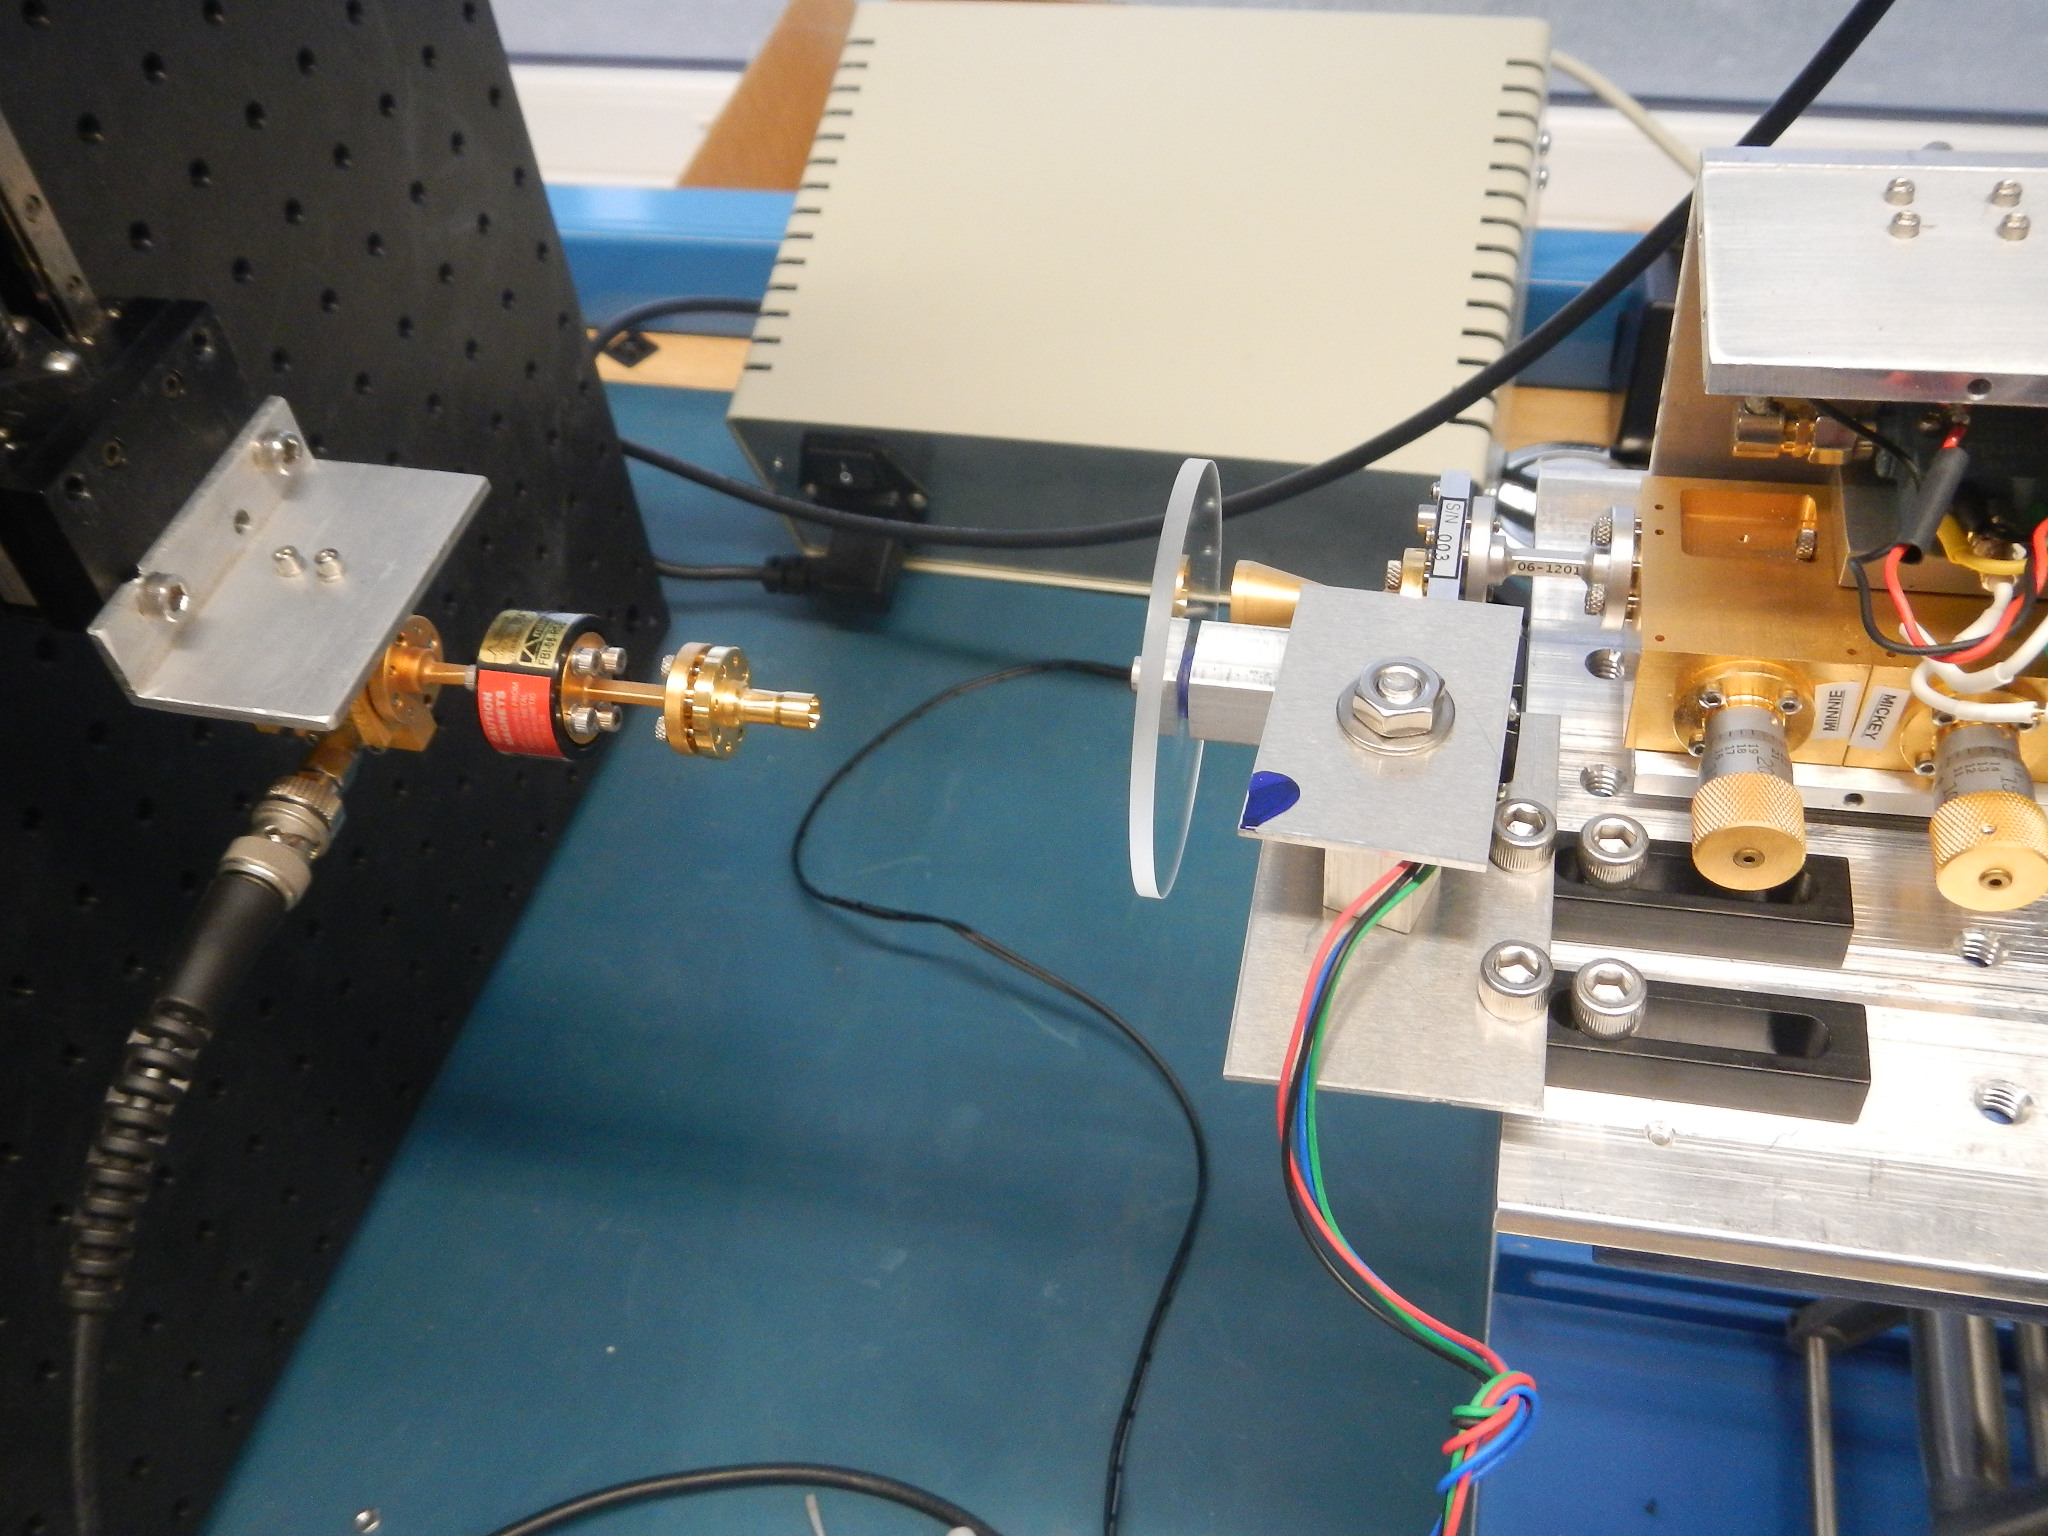

In [3]:
Image(filename='/artemis/photos/DSCN1186.JPG',width=800)

## Get the data

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import seaborn as sns
sns.set_context('poster')
sns.set_palette(sns.palettes.hls_palette(21))

In [6]:
from kid_readout.measurement.io.easync import EasyNetCDF4
from kid_readout.analysis.resources import skip5x4

In [7]:
nc = EasyNetCDF4('/artemis/readout/hwp_mapping/2016-04-29_211446.nc')

In [8]:
z = nc.map_20160429211446.z[:]

In [9]:
x = nc.map_20160429211446.x[:]
y = nc.map_20160429211446.y[:]
hwp_step = nc.map_20160429211446.hwp_step[:]

In [10]:
x.shape

(21,)

In [11]:
z.shape

(21, 21, 108)

### Quick look
Here is an example slice through the data, showing response as a function of HWP angle for each step in the X direction with a fixed Y offset.

The expected $4f$ response is clearly evident

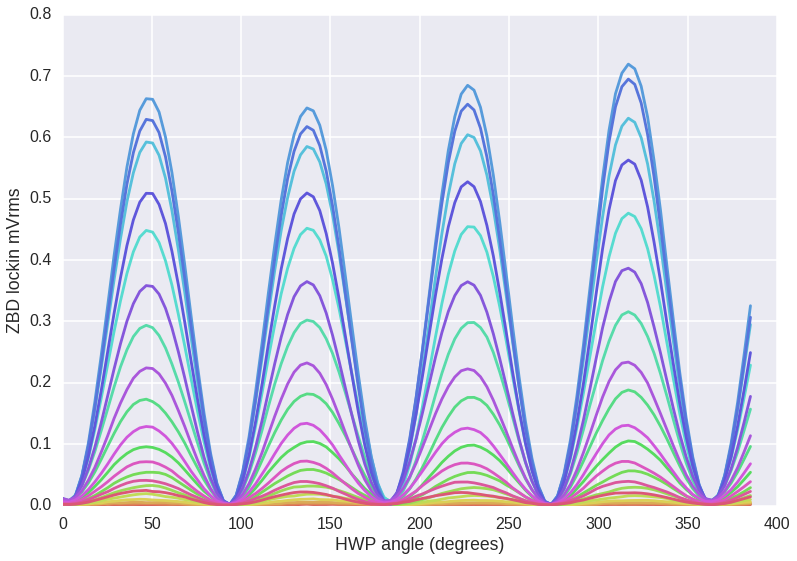

In [12]:
_ = plot(hwp_step*360/400.,1000*z[:,9,:].T)
ylabel('ZBD lockin mVrms')
xlabel('HWP angle (degrees)')

### Grid of HWP response
Here is a plot of the response vs. HWP angle for a subset of the full grid (7x7 out of the full 21x21 grid, showing every 3rd step). The y-axis is logarithmic and constant between the subplots.

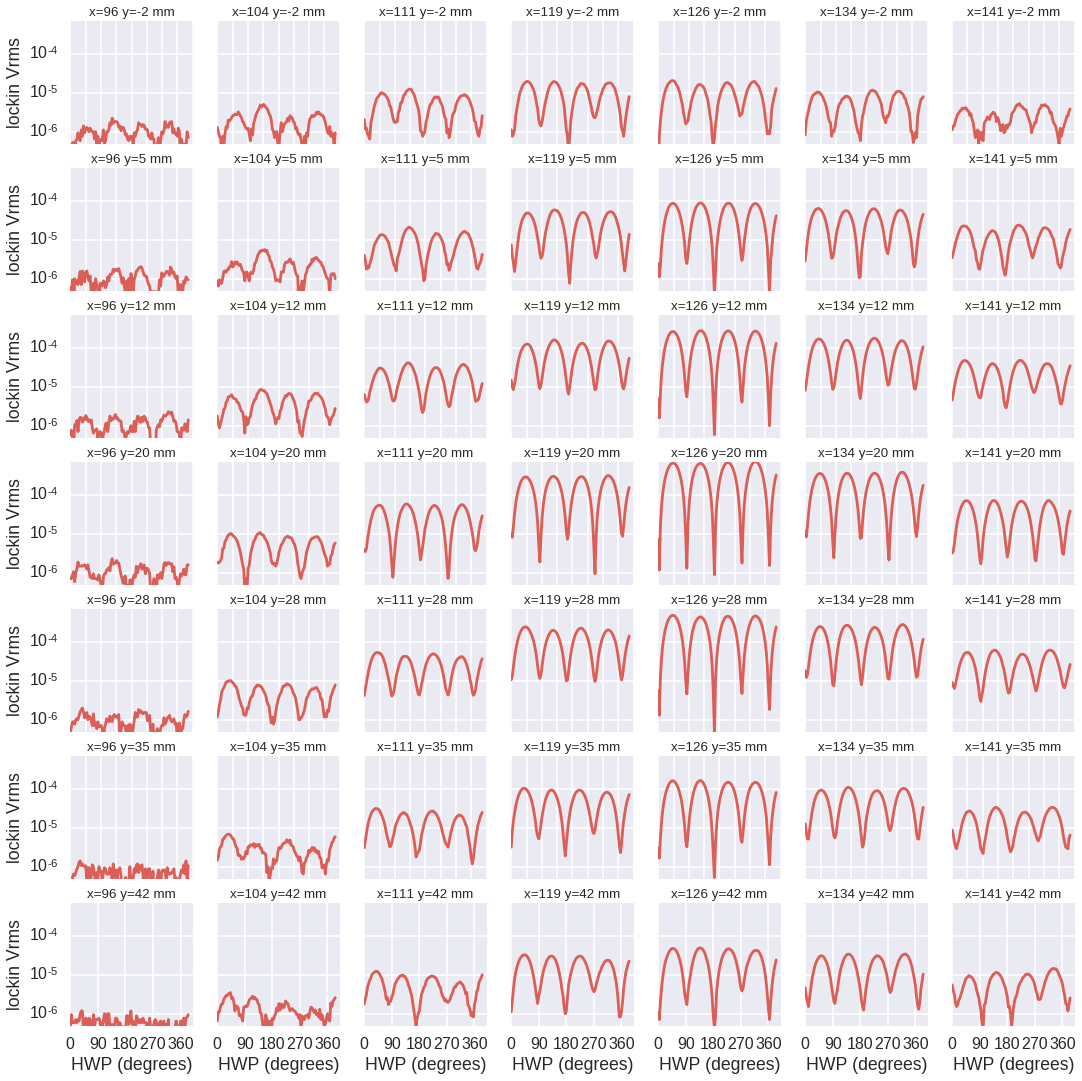

In [13]:
fig,axs = subplots(7,7,figsize=(18,18))
for xx in range(7):
    for yy in range(7):
        ax = axs[yy,xx]
        ax.semilogy(hwp_step*360/400.,z[xx*3,yy*3,:])
        ax.set_ylim(.5e-6,.7e-3)
        ax.set_title("x=%.0f y=%.0f mm" % (x[xx*3]/80.,y[yy*3]/80.),size='x-small')
        if xx != 0:
            ax.yaxis.set_ticklabels([])
        else:
            ax.set_ylabel('lockin Vrms')
        if yy != 6:
            ax.xaxis.set_ticklabels([])
        else:
            ax.xaxis.set_major_locator(plt.MultipleLocator(90.))
            ax.set_xlabel('HWP (degrees)')

### Modulation efficiency
One way to evaluate the response is to look at the ratio between the peak of the HWP response to the minimum. Presumably the power detected at the minimum represents unwanted polarization leakage, and a higher maximum means better transmission of the desired polarization.

Each pixel in the following plot corresponds to an x,y location of the translation stage and the color of the pixel shows the ratio of the maximum response over the minimum response during one revolution of the HWP on a dB scale. 

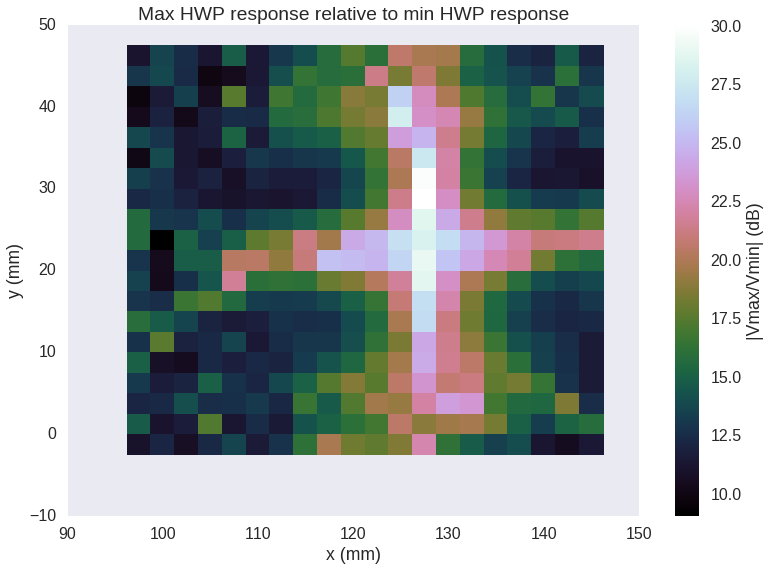

In [14]:
maxs = z.max(2)
mins = z.min(2)
mins[mins==0] = 1e-7
pcolormesh(x/80.,y/80.,10*np.log10(maxs/mins).T,cmap=cm.cubehelix)
cb = colorbar()
xlabel('x (mm)')
ylabel('y (mm)')
cb.set_label('|Vmax/Vmin| (dB)')
title('Max HWP response relative to min HWP response')

### Polarization leakage?
The next plot is similar to the previous, but just shows the minimum value of the HWP response on a dB scale. It seems like the minimum value of the response should give an indication of unwanted polarization leakage. Plots further on seem to show that this is associated with the $2f$ component of the HWP.

A 20-element 4.8 mm pitch horn array is drawn on top for scale.

Clearly the cross-shaped peak in the previous plot corresponds to the reduced minimum value of the response along the same cross-shaped region in this plot.

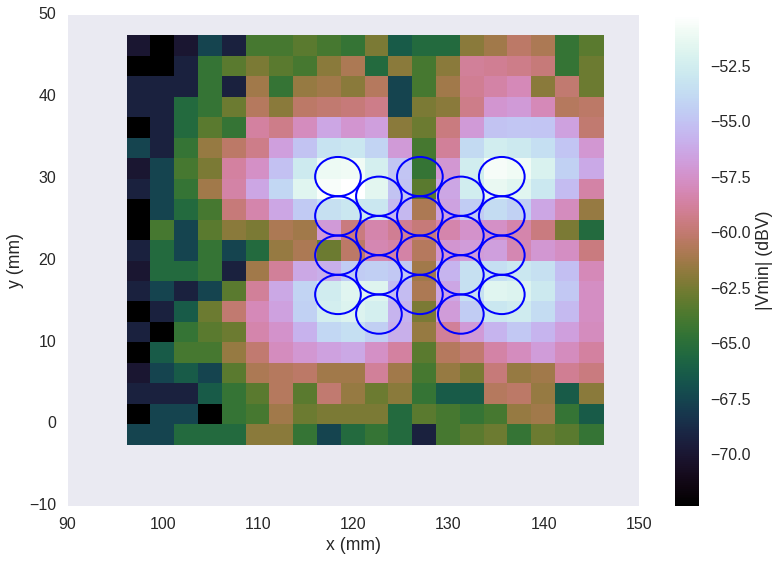

In [15]:
maxs = z.max(2)
mins = z.min(2)
mins[mins==0] = 1e-7
pcolormesh(x/80.,y/80.,10*np.log10(mins).T,cmap=cm.cubehelix)
cb = colorbar()
xlabel('x (mm)')
ylabel('y (mm)')
cb.set_label('|Vmin| (dBV)')
ax = gca()
xoffset = 127
yoffset = 23
for k in range(20):
    rawx,rawy = skip5x4.coordinate_array[k,:]
    xx = (rawx - 2)*4.3 +xoffset
    yx = (rawy - 2)*4.8 +yoffset
    #x,y = y,x
    horn = Circle((xx,yx),radius=4.8/2,fill=False,lw=2,edgecolor='b',axes=ax,transform=ax.transData)
    ax.add_artist(horn)

## HWP Harmonics
Next we're going to look at the maps of each harmonic of the HWP response signal as a function of x,y location. To compute the harmonics, we simply take a DFT to get the Fourier series. To simplify the analysis by avoiding edge effects, we take the DFT of exactly one revolution of the HWP, which corresponds to 100 steps in this data file. 

In [16]:
ffz = np.fft.rfft(z[:,:,:100],axis=2)

### Plots of each harmonic
Each row of the following plot shows the map of the signal in a given harmonic. The left panel of each row is the amplitude with a dB power scale. The right panel shows the phase.

The first row is the DC component, for which the phase is identically zero because the HWP response is a real signal. I think the power map should correspond to the standard total power beam-map. 

The second row corresponds to the first harmonic: signal modulated at the HWP rotation frequency.

My uninformed opinion is that the odd harmonic responses are largely driven by the mechanical "wobble" of the HWP as it turns in the current crude setup.

The second harmonic seems to show the same cross-shaped pattern we saw in the "polarization leakage" plot above, so I suspect it is also related to some non-ideality of the setup.

The fourth harmonic (desired) response seems to look quite smooth.

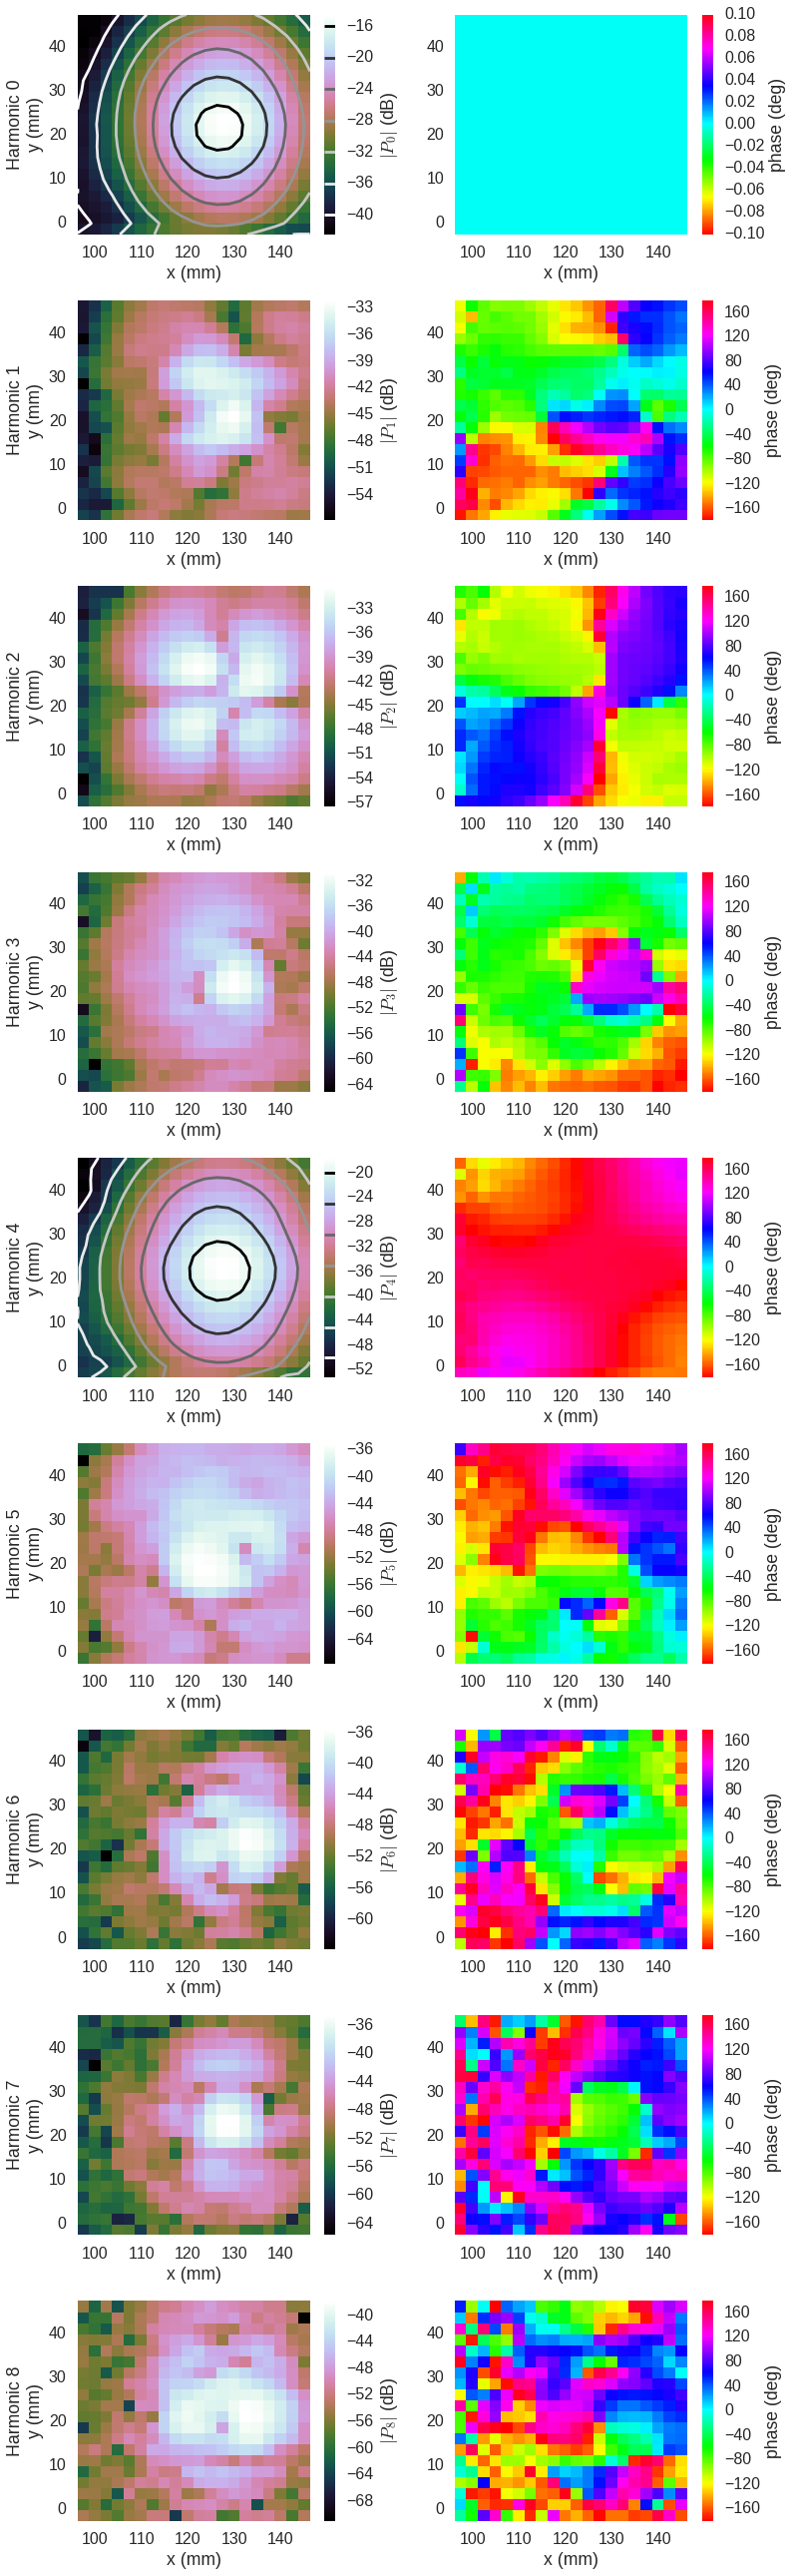

In [20]:
nharm = 9
fig,axs = subplots(nharm,2,figsize=(12,5*nharm))
fig.subplots_adjust(wspace=.3, hspace=0.3)
for harm in range(nharm):
    pc = axs[harm,1].pcolormesh(x/80.,y/80.,np.degrees(np.angle(ffz[:,:,harm])).T,cmap=cm.hsv)
    cb = fig.colorbar(pc,ax=axs[harm,1])
    cb.set_label('phase (deg)')
    pc = axs[harm,0].pcolormesh(x/80.,y/80.,10*np.log10(np.abs(ffz[:,:,harm]).T),cmap=cm.cubehelix)
    cb = fig.colorbar(pc,ax=axs[harm,0])
    cb.set_label('$|P_%d|$ (dB)' % harm)
    if harm in [0,4]:
        cs = axs[harm,0].contour(x/80.,y/80.,10*np.log10(np.abs(ffz[:,:,harm]).T),color='k')
        cb.add_lines(cs)
        xlim_ = axs[harm,0].get_xlim()
        ylim_ = axs[harm,0].get_ylim()
    for c in [0,1]:
        axs[harm,c].set_xlim(xlim_)
        axs[harm,c].set_ylim(ylim_)
    axs[harm,0].set_ylabel('Harmonic %d\ny (mm)' % (harm))
    axs[harm,0].set_xlabel('x (mm)')
    axs[harm,1].set_xlabel('x (mm)')

    

### Plots of each harmonic relative to the total response
Each row of the following plot shows the map of the signal in a given harmonic relative to the DC (harmonic 0) response. Thus the total power beam response should mostly be normalized out. As before, the left panel of each row is the amplitude with a dB power scale. The right panel shows the phase.

The first row corresponds to the first harmonic: signal modulated at the HWP rotation frequency.

After accounting for the total power beam response, the desired 4th harmonic signal looks even smoother.

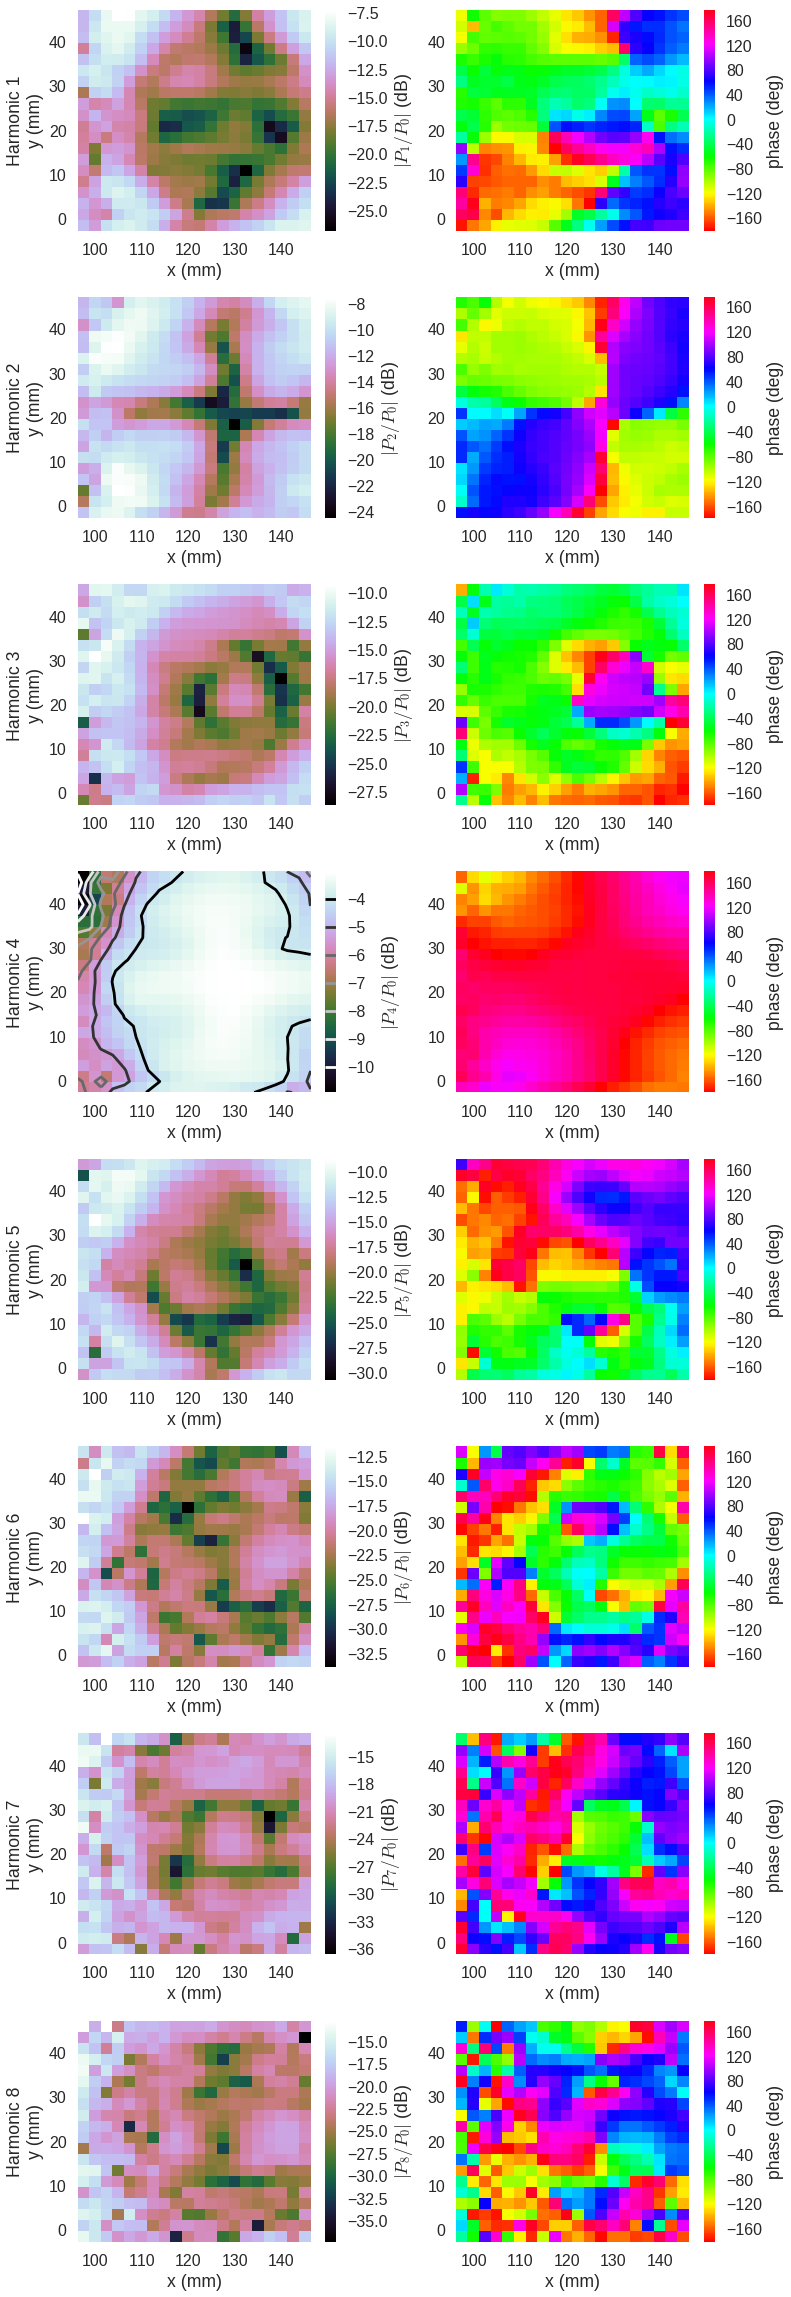

In [21]:
nharm = 9
fig,axs = subplots(nharm-1,2,figsize=(12,5*(nharm-1)))
fig.subplots_adjust(wspace=.3, hspace=0.3)
for harm in range(1,nharm):
    pc = axs[harm-1,1].pcolormesh(x/80.,y/80.,np.degrees(np.angle(ffz[:,:,harm]).T),cmap=cm.hsv)
    cb = fig.colorbar(pc,ax=axs[harm-1,1])
    cb.set_label('phase (deg)')
    pc = axs[harm-1,0].pcolormesh(x/80.,y/80.,10*np.log10(np.abs(ffz[:,:,harm]/ffz[:,:,0]).T),cmap=cm.cubehelix)
    cb = fig.colorbar(pc,ax=axs[harm-1,0])
    cb.set_label('$|P_%d / P_0|$ (dB)' % harm)
    if harm in [4]:
        cs = axs[harm-1,0].contour(x/80.,y/80.,10*np.log10(np.abs(ffz[:,:,harm]/ffz[:,:,0]).T),color='k')
        cb.add_lines(cs)
        xlim_ = axs[harm-1,0].get_xlim()
        ylim_ = axs[harm-1,0].get_ylim()
    for c in [0,1]:
        axs[harm-1,c].set_xlim(xlim_)
        axs[harm-1,c].set_ylim(ylim_)

    axs[harm-1,0].set_ylabel('Harmonic %d\ny (mm)' % (harm))
    axs[harm-1,0].set_xlabel('x (mm)')
    axs[harm-1,1].set_xlabel('x (mm)')

    
    